#### PoS Rewards
Proof-of-Stake (PoS) realizes Sybil resistance by exclusively allocating validation work, and corresponding compensation, to service-providers who have locked non-trivial sums of value (hereafter _stakers_). Game theoretic devices, which coordinate, mediate and penalize stakers, are built upon this eligibility prerequisite of provably committed capital. Heir apparent to energy-inefficient predecessors, Proof-of-Stake protocols have recently come under increasing academic scrutiny – including the mechanisms which incentivize staker participation, and the long-term economic outcomes of flawed reward allocation functions in particular.

#### Variable incentive model
PoS rewards are typically generated by minting new units of the network’s native token and distributing them exclusively to active stakers. This implies that the reward's value is contrived via the dilution of token holdings belonging to _non-recipients_. The percentage that the circulating token supply is expected to grow per year, through the issuance of new tokens as rewards, is commonly referred to as the nominal inflation rate ($I_{nom}$). 

The central focus of this notebook is what we describe as the _variable incentive_ model. At any given instance of reward generation and issuance, the size of the reward received by any one staker (and their delegators) varies based on the percentage of tokens staked out of the entire supply in that instance – the staking rate ($S_{rate}$). The staking rate reflects the total capital commitment to the network by stakers (including tokens committed indirectly by delegators), and ostensibly, the total capacity for service provision. Since tokens distributed as rewards are not immune from dilutionary effects, calculating the 'true' value of the reward must also take this into account [1]. We may now construct an expression for a reward's true value in a given instance, referred to as the real yield ($Y_{real}$): 

$$ Yield_{real} = \frac{I_{nom}}{S_{rate}} - I_{nom} $$

The real yield can be summarized as the annualized percentage growth of an arbitrary staked holding of tokens, that has been modified, via the above equation, to reflect its true value at each timestamp. 

The variable incentive model is far from an unavoidable, reluctantly accepted design flaw. Rather, the inverse relationship between staker participaton (i.e. the staking rate) and true reward value is an attempt to programmatically regulate service-provider participation within expedient bounds. An implicit assumption that underpins this model's design is that stakers' heuristics/preferences prioritize returns over short-term horizons, and bond/unbond tokens on a frequent basis. A loose analogy for this class of rational agent are day-traders (as opposed to value investors), who not only pay greater attention to ephemeral indicators and deviations, but act upon them. With variable incentives, the supposed rational reaction to observing a period with relatively high real yield is to commence staking with passively held tokens or increase the size of an existing stake, amongst prospective and active service-providers respectively. Equally, the model assumes the rational reaction to a period with relatively low real yield is to reduce the size of an existing stake or cease staking altogether. In this way, the variable incentive model is designed to balance and moderate the staking rate. 

One may infer this rationale, and underlying assumptions, from the proactive modification of certain reward mechanisms, which effectively double-down on the principle of the variable incentive model. Though the exact parameters are different, the Proof-of-Stake networks Cosmos, Livepeer and Ethereum 2.0 utilize mechanisms that adjust the total reward budget (nominal inflation rate) in response to a fluctuating staking rate. Instead of expanding the reward budget in response to greater participation, which would resemble a traditional subsidy model, the exact opposite is enforced. When participation rises beyond a fixed target rate (66.7% and 50% of the circulating supply for Cosmos and Livepeer, respectively), the total reward budget decreases, and vice versa. In Ethereum 2.0's case, there is no explicit target staking rate, but the current leading proposal for reward design advocates maximum network issuance as an inverse function of the total sum of tokens staked. In all cases, this design further increases the dependence of the the true reward value on the collective, day-to-day (or block-to-block) decision-making of active stakers/delegators, dormant stakers/delegators and passive token-holders, with respect to their staking activity. 

#### Elevated Staking Rates
The staking rate, and its evolution/volatility over time, are imperfect but critical public indicators of network stability, diversity and staked wealth. Thus, protocol designers seek to influence the staking rate and maintain it within expedient bounds. The upper and lower bounds of expediency are not formally identified or quantified in network documentation, but there are clear problems with both extremes. The dangers of a depressed staking rate are well documented; undermining network stability, diversity and staked wealth, any of which increase vulnerability to potentially fatal collusion attacks. Elevated staking rates are unlikely to engender as catastrophic an outcome as the opposite extreme, but create conditions for deep-seated and potentially irreparable problems to emerge over the long-term. Firstly, when the vast majority of native tokens are staked, this limits the availability of the token. Prospective network users, who must acquire the native token and use it to pay fees, encounter the dual frictions of low liquidity and associated volatility. Secondly, it has been argued that a predominant tendency for token-holders to lock their tokens for indefinite time frames ('stake hoarding'), when combined with a fixed, finite token supply, can contribute to deflationary forces [2]. Deflation, or even the spectre of it, not only stymies the native token's utility as a payment token, casting it as an asset rather than a currency, it also reinforces the expected utility of holding the token for extended time frames – encouraging further stake hoarding.  

Further undesirable dynamics may occur with respect to the composition and behavior of the staker array, given that perennially elevated staking rates are a form of market oversupply. Because rewards (and transaction fees) are divided up amongst all active stakers, an oversupplied network will fail to sufficiently support and subsidize some stakers' operations. The stakers most likely to survive periods of chronic oversupply, and deficient compensation, are those with the greatest resources at their disposal. Crucially, market oversupply is not necessarily self-correcting. A dip in the real yield can conceivably induce a corresponding rise in the staking rate, as stakers rich and poor attempt to increase their fractional share (and commensurate rewards), to make up the loss. Oversupply, wealth concentration and detrimental feedback loop dynamics are explored in later sections. 

#### Empirical Analysis RQs
To illuminate these dynamics, this paper examines the historical relationship between two public network statistics; (1) the true reward value _real yield_) received by stakers/delegators on a daily basis, and (2) the subsequent, collective decision to increase, maintain or decrease stake sizes, reflected in the _staking rate_. From these results, we evaluate and discuss the efficacy of the variable incentive model in regulating staking, and by extension, the aforementioned model of agent rationality that underpins its design. The empirical analysis focuses on prominent Proof-of-Stake networks that have been active for at least 24 months – Tezos,  Cosmos & Livepeer.

Research questions:

**RQ1** – Using public network statistics, what is ascertainable about the relationship between the real yield and the subsequent staking rate?  

**RQ2** – How does the model of stakers/delegators as preferring short-term planning horizons and frequent bonding/unbonding, on which the variable incentive component of orthodox reward mechanisms is implicitly based, perform in practice?

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import datetime
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import kendalltau, pearsonr, spearmanr

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 10

To get a sense of how the staking rate and real yields have varied historically, let's generate two simple time series graphs.

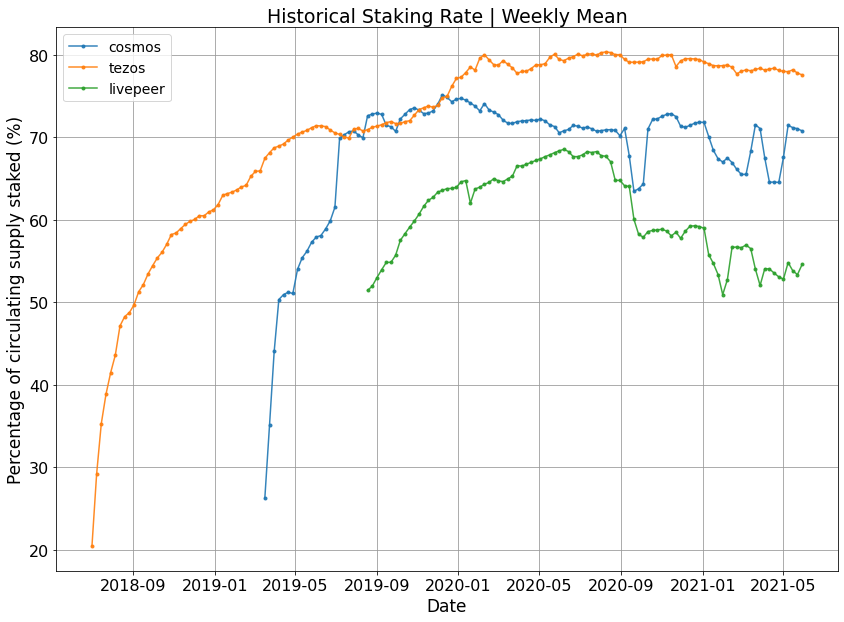

In [10]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    plt.plot(SRnetworks[net]['total_staked'], label = net, alpha=0.9, marker = 'o', ms =3)
plt.title('Historical Staking Rate | Weekly Mean', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Percentage of circulating supply staked (%)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.grid(b=True, which='major', color='#999999', linestyle='-')
#plt.savefig('Hist_SR.pdf')

Since their respective launches, Tezos, Cosmos and Livepeer all saw steadily increases in the staking rate launches, despite the real yields' correspondingly steady decline. Of the three networks, only Livepeer has seen any meaningful reduction in the staking rate, with the other two networks having experienced an elevated staking rate from late 2019 until mid-2021. 

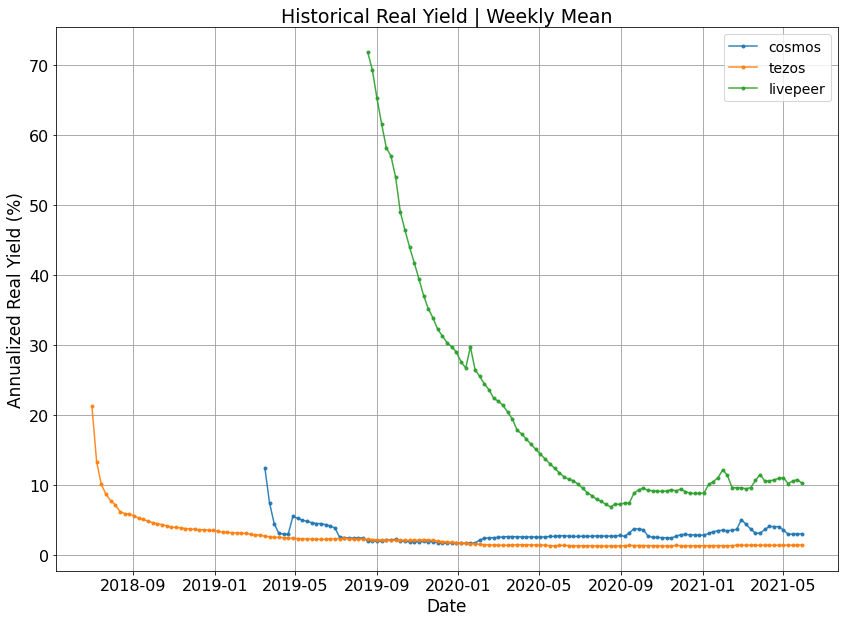

In [11]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    plt.plot(SRnetworks[net]['adjustedReward'], label = net, alpha=0.9, marker = 'o', ms =3)
plt.title('Historical Real Yield | Weekly Mean', fontsize=19)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Annualized Real Yield (%)', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc=0, fontsize=14)
#plt.yscale('log')
plt.grid(b=True, which='major', color='#999999', linestyle='-')
#plt.savefig('Hist_RY.pdf')

The times series for all three networks and both variables exhibit time-dependent/trending structure in their raw form, and hence are almost certainly non-stationary. The time series are also strongly correlated with themselves, confirmed via standard tests. Though fairly common in time series data, this lack of stationarity renders the results of both Pearson cross-correlation and Granger predictive causality tests far less meaningful. Non-stationarity can be partially or fully remedied with data transformation techniques. The first transformation step is detrending, which involves generating a linear regression of the time series, then subtracting this trendline from the data. This reduces the time-dependency of the series. The next transformation step is differencing, which reduces the autocorrelation of the data. The transformed data are also run through an Augmented Dickey-Fuller test to confirm stationarity.

In [12]:
def lump(df, size):
    for column in df:
        df[column] = df[column].groupby(np.arange(len(df))//size).mean()
        
def detrend(df):
    for column in df:
        days = [i for i in range(0,len(df[column]))]
        days = np.reshape(days, (len(days), 1))
        model = LinearRegression()
        col_values = df[column]
        model.fit(days, df[column])
        col_trend = model.predict(days)
        detrended_col_values = [col_values[i] - col_trend[i] for i in range(0, len(df[column]))]
        df[column] = detrended_col_values
        
def dif(df):
    for column in df:
        df[column] = df[column].diff(periods=-1)
        
def ipl(df):
    for column in df:
        df[column] = df[column].interpolate(method = 'linear', limit_direction = 'both')
        
def manual_downsample(df):
    for column in df:
        df[column] = df[column].rolling(2).mean() 
        df[column] = df[column].iloc[::2, :]

If the staking rate at a given timestamp is indeed a function of the real yield at some (presently unknown) preceding timestamp, as wide a range of time-lags as possible must be evaluated. This involves shifting the real yield time series against the staking rate time series. Since the network protocols under examination are deliberately designed such that the real yield value is an inverse function of the staking rate at the corresponding timestamp, it is not possible to discern a relationship in the reverse direction (real yield influencing staking) at a time-lag of zero. However, rules surrounding the ceasing of staking (the unbonding delay) mean that unambiguous causality would not surface at a time-lag of zero in any case.

The raw data contain between 4 and 11 entries per day. Anecdotally, stakers and delegators are unlikely to make decisions relating to their stake size every few hours. Indeed, even if a staker programmed an instantaneous response to fluctuations in the real yield, any evidence of causality would be obfuscated by the reverse, known impact of the staking rate on the real yield. Nonetheless, we cannot assume the cadence with which they react to the real yield, if they do at all. Nor would this cadence be uniform across a diverse population of stakers and delegators that have heterogeneous planning horizons and bonding/unbonding frequency preferences. Hence, we downsample the data to daily, weekly, bi-monthly and monthly durations, using the arithmetic mean for both real yield and staking rate variables.

In order to gauge a wider range of possible staker reactions to variable incentives, the analysis converts each real yield entry, based on the native token's exchange rate to USD, and includes this as a separate result on all graphs.

In [13]:
def lag_Pcorr(df, lag_start, lag_end, feature, target, lump):
    df_temp = pd.DataFrame()
    results = {}
    for i in range(lag_start, lag_end):
        df_temp[feature] = df[feature].shift(i)
        df_temp = df_temp.dropna()
        results[i*lump] = df_temp[feature].corr(df[target])
        df_temp[feature] = df[feature]
    return results

def lag_Scorr(df, lag_start, lag_end, feature, target, lump):
    df_temp = pd.DataFrame()
    results = {}
    for i in range(lag_start, lag_end):
        df_temp[feature] = df[feature].shift(i)
        df_temp = df_temp.dropna()
        results[i*lump] = df_temp[feature].corr(df[target], method='spearman')
        df_temp[feature] = df[feature]
    return results

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def lag_Pcorr_PV(df, lag_start, lag_end, feature, target, lump):
    df_temp = pd.DataFrame()
    p_values = {}
    for i in range(lag_start, lag_end):
        df_temp[feature] = df[feature].shift(i)
        df_temp = df_temp.dropna()
        p_values[i*lump] = df_temp[feature].corr(df[target], method=pearsonr_pval)
        df_temp[feature] = df[feature]
    return p_values

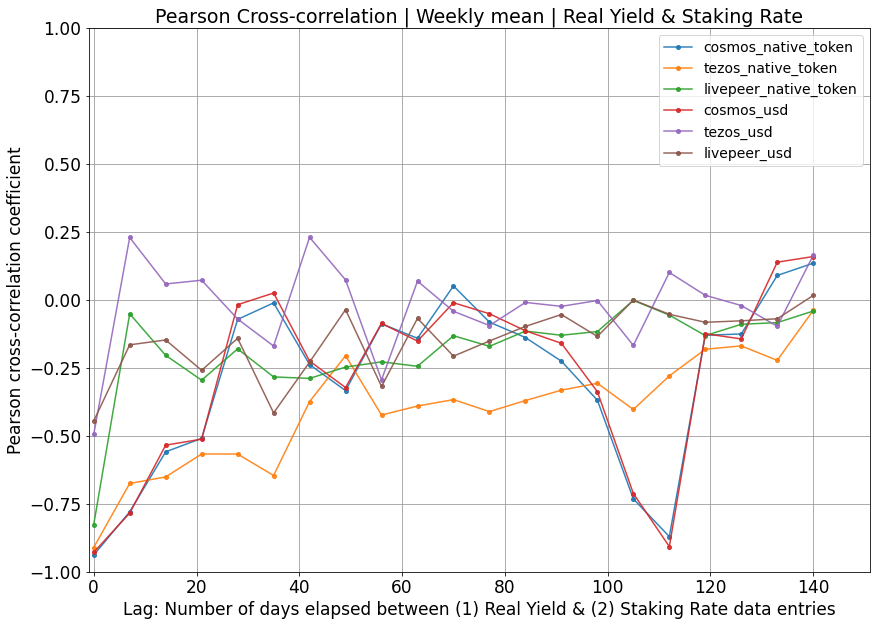

In [18]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('W').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/7), 'adjustedReward', 'total_staked', int(365/52))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/7), 'aRUSD', 'total_staked', )

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Weekly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

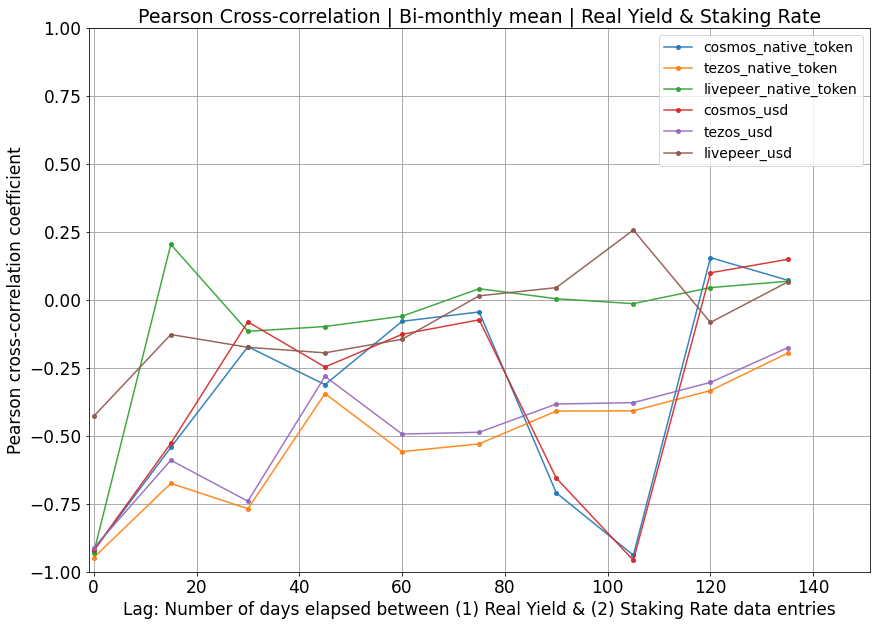

In [22]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('SMS').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/24))), 'adjustedReward', 'total_staked', int(365/24))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/int(365/24)), 'aRUSD', 'total_staked', int(365/24))

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Bi-monthly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

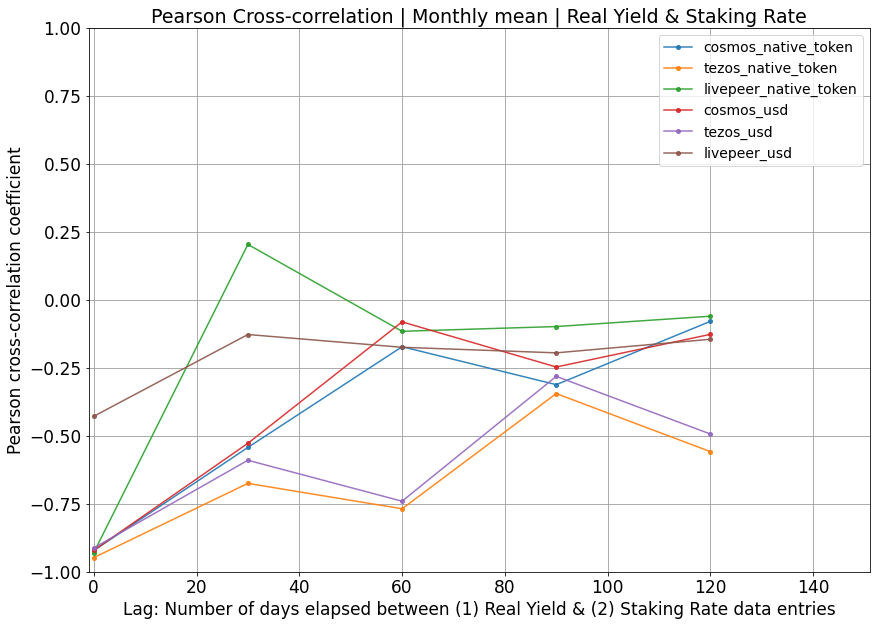

In [23]:
SRnetworks = {}
SRnetworks['cosmos'] = pd.read_csv(r'cosmos.csv')
SRnetworks['tezos'] = pd.read_csv(r'tezos.csv')
SRnetworks['livepeer'] = pd.read_csv(r'livepeer.csv')

SR_corr = {}
SR_corrUSD = {}
for net in SRnetworks:
    SRnetworks[net] = SRnetworks[net].dropna()
    SRnetworks[net]['dateTime'] = pd.to_datetime(SRnetworks[net]['timestamp'], unit='s')
    SRnetworks[net] = SRnetworks[net].set_index('dateTime')
    SRnetworks[net]['aRUSD'] = SRnetworks[net]['adjustedReward'] * SRnetworks[net]['priceUsd']
    ipl(SRnetworks[net])
    detrend(SRnetworks[net])
    dif(SRnetworks[net])
    SRnetworks[net] = SRnetworks[net].resample('SMS').mean()
    SR_corr[net] = lag_Pcorr(SRnetworks[net], 0, int(150/(int(365/12))), 'adjustedReward', 'total_staked', int(365/12))
    SR_corrUSD[net] = lag_Pcorr(SRnetworks[net], 0, int(150/int(365/12)), 'aRUSD', 'total_staked', int(365/12))

for net in SR_corr:
    plt.plot(*zip(*sorted(SR_corr[net].items())), label = net+'_native_token', alpha=0.9, marker = 'o', ms =4)
for net in SR_corrUSD:
    plt.plot(*zip(*sorted(SR_corrUSD[net].items())), label = net+'_usd', alpha=0.9, marker = 'o', ms =4)
plt.title('Pearson Cross-correlation | Monthly mean | Real Yield & Staking Rate', fontsize=19)
plt.xlabel('Lag: Number of days elapsed between (1) Real Yield & (2) Staking Rate data entries', fontsize=17)
plt.ylabel('Pearson cross-correlation coefficient', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(loc=0, fontsize=14)
plt.axis([-1, 151, -1,1])
plt.grid(b=True, which='major', color='#999999', linestyle='-')

[1] Variable block generation times and non-programmatic events also impact the circulating supply and therefore the true value of issued tokens. An example of the latter is a network’s foundation, treasury or reserve releasing new tokens into the supply, outside of a public reward schedule. However, the fluctuating staking rate and global dilution account for almost the entire difference between the nominal inflation rate and the real yield, and so other factors of this kind are discounted in this analysis.

[2] Deuber et al [https://link.springer.com/chapter/10.1007%2F978-3-030-57808-4_16]